In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
#Read the csv file
df = pd.read_csv('../../../data/GE.csv')
print(df.head()) #7 columns, including the Date. 

         Date      Open      High       Low     Close  Adj Close  Volume
0  1962-01-02  6.009615  6.109776  5.949519  5.989583   1.009675  269568
1  1962-01-03  5.959535  5.959535  5.909455  5.929487   0.999544  184704
2  1962-01-04  5.929487  5.979567  5.809295  5.859375   0.987724  229632
3  1962-01-05  5.859375  5.869391  5.608974  5.709135   0.962398  340704
4  1962-01-08  5.709135  5.709135  5.528846  5.699119   0.960709  386880


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

15259   2022-08-15
15260   2022-08-16
15261   2022-08-17
15262   2022-08-18
15263   2022-08-19
15264   2022-08-22
15265   2022-08-23
15266   2022-08-24
15267   2022-08-25
15268   2022-08-26
15269   2022-08-29
15270   2022-08-30
15271   2022-08-31
15272   2022-09-01
15273   2022-09-02
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


<AxesSubplot:>

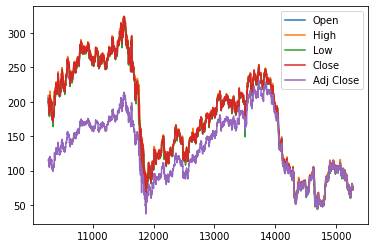

In [5]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(5000)
df_for_plot.plot.line()

Modeling

In [6]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [7]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [8]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (15260, 14, 5).
trainY shape == (15260, 1).


In [9]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)


Epoch 1/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0241 - val_loss: 9.4597e-04
Epoch 2/100
14/14 [==============================] - 1s 48ms/step - loss: 0.0244 - val_loss: 8.0919e-04
Epoch 3/100
14/14 [==============================] - 1s 47ms/step - loss: 0.0236 - val_loss: 0.0010
Epoch 4/100
14/14 [==============================] - 1s 46ms/step - loss: 0.0242 - val_loss: 0.0011
Epoch 5/100
14/14 [==============================] - 1s 45ms/step - loss: 0.0232 - val_loss: 9.6039e-04
Epoch 6/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0236 - val_loss: 6.1738e-04
Epoch 7/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0230 - val_loss: 0.0012
Epoch 8/100
14/14 [==============================] - 1s 51ms/step - loss: 0.0233 - val_loss: 0.0013
Epoch 9/100
14/14 [==============================] - 1s 52ms/step - loss: 0.0235 - val_loss: 8.2207e-04
Epoch 10/100
14/14 [==============================] - 1s 50ms/step - loss: 0.022

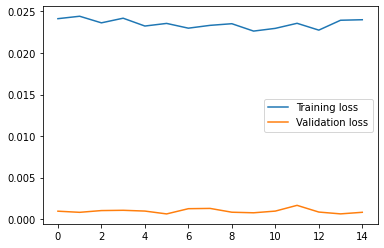

In [25]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=1000, validation_split=0.1, verbose=1, callbacks=early_stop)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [30]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_days_for_prediction=60  #let us predict past 15 days
n_past = n_days_for_prediction + n_past


predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

[Timestamp('2022-05-17 00:00:00', freq='C'), Timestamp('2022-05-18 00:00:00', freq='C'), Timestamp('2022-05-19 00:00:00', freq='C'), Timestamp('2022-05-20 00:00:00', freq='C'), Timestamp('2022-05-23 00:00:00', freq='C'), Timestamp('2022-05-24 00:00:00', freq='C'), Timestamp('2022-05-25 00:00:00', freq='C'), Timestamp('2022-05-26 00:00:00', freq='C'), Timestamp('2022-05-27 00:00:00', freq='C'), Timestamp('2022-05-31 00:00:00', freq='C'), Timestamp('2022-06-01 00:00:00', freq='C'), Timestamp('2022-06-02 00:00:00', freq='C'), Timestamp('2022-06-03 00:00:00', freq='C'), Timestamp('2022-06-06 00:00:00', freq='C'), Timestamp('2022-06-07 00:00:00', freq='C'), Timestamp('2022-06-08 00:00:00', freq='C'), Timestamp('2022-06-09 00:00:00', freq='C'), Timestamp('2022-06-10 00:00:00', freq='C'), Timestamp('2022-06-13 00:00:00', freq='C'), Timestamp('2022-06-14 00:00:00', freq='C'), Timestamp('2022-06-15 00:00:00', freq='C'), Timestamp('2022-06-16 00:00:00', freq='C'), Timestamp('2022-06-17 00:00:00'

In [31]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

2/2 [==============================] - 0s 3ms/step


In [33]:
trainX[-60]

array([[-0.21119758, -0.20410118, -0.20840418, -0.20397898,  0.16286579],
       [-0.20060932, -0.20504474, -0.21979055, -0.20865281,  0.15601132],
       [-0.20146786, -0.20542217, -0.20300043, -0.20664974,  0.15894896],
       [-0.21377307, -0.21985884, -0.23146639, -0.21561593,  0.14579943],
       [-0.22579218, -0.22250092, -0.22606264, -0.21552053,  0.1459393 ],
       [-0.20909899, -0.19306139, -0.20599182, -0.19186507,  0.18063171],
       [-0.18935334, -0.18296515, -0.18389454, -0.17517273,  0.20511213],
       [-0.18305766, -0.18051183, -0.17646441, -0.17965582,  0.19853741],
       [-0.17227858, -0.17673753, -0.18678934, -0.18700049,  0.18776592],
       [-0.18238993, -0.18409739, -0.18215763, -0.18242199,  0.19448061],
       [-0.1945998 , -0.19834537, -0.19663183, -0.19224662,  0.18007212],
       [-0.18343915, -0.18758864, -0.18601743, -0.19196047,  0.18049174],
       [-0.19297812, -0.18890963, -0.19180709, -0.18242199,  0.19448061],
       [-0.19507671, -0.18768301, -0.1

<ipython-input-32-e568de85401c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
c:\Users\Pablo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Pablo\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments witho

<AxesSubplot:xlabel='Date', ylabel='Open'>

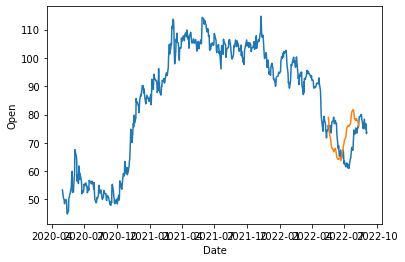

In [32]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])

In [29]:
df[-60:]

,Date,Open,High,Low,Close,Adj Close,Volume
15214,2022-06-09,76.889999,77.050003,74.750000,74.779999,74.690811,5055500
15215,2022-06-10,73.019997,73.160004,70.739998,71.230003,71.145050,9584900
15216,2022-06-13,69.470001,70.000000,67.139999,67.720001,67.639236,9459400
15217,2022-06-14,67.949997,68.910004,67.529999,68.050003,67.968842,5379700
15218,2022-06-15,68.959999,70.019997,67.800003,69.099998,69.017586,6589400
15219,2022-06-16,67.029999,67.239998,64.849998,65.290001,65.212135,9065300
15220,2022-06-17,65.190002,66.730003,64.540001,66.000000,65.921288,9002200
15221,2022-06-21,67.459999,68.059998,65.709999,65.750000,65.671585,8082000
15222,2022-06-22,64.180000,65.400002,64.169998,64.540001,64.463028,9702300
15223,2022-06-23,64.370003,65.080002,63.080002,64.070000,63.993587,6754300
